# Homework 2

### Due Date: Thursday, September 27, 2018

### Getting Started

- Training optimal policies / value functions can take very long, so be sure to start solving the problems early to give yourself enough time to finish training everything.
- Please save any plots you generate and add them to the notebook. We will not rerun your code for you.

# Question 1: Modeling Driving Behaviors via Regression

In this problem, we will explore the potential of using neural network models to approximate the acceleration (or car-following) behavior of individual vehicles given certain local observations. Specifically, we will try to estiamte the acceleration $a_\alpha$ of vehicle $\alpha$ using only information on its bumper-to-bumper gaps with the lead vehicle $s_\alpha = x_{\alpha-1} - x_\alpha$, the speed of the ego vehicle $v_\alpha$, and the speed of the lead vehicle $v_{\alpha-1}$. While the majority of this course focuses on sequential decision making tasks, regression problems such as these on deep neural networks may play a significant role in the future of transportation modeling.

<img src="img/micro_data.png" width="600">

### a. NGSIM dataset

[NGSIM](https://ops.fhwa.dot.gov/trafficanalysistools/ngsim.htm) is a collection of datasets providing microscopic data on vehicles on the US 101 and I-80 for a total set of 6 intervals of 15 min, sampled at 0.1/s. It is one of the largest sets of open-source microscopic (per-vehicle) transportation data, and is a good candidate for modeling human driver behavior.

We begin by importing a processed and filtered version of the dataset. In order to do so, go to https://data.transportation.gov/Automobiles/Next-Generation-Simulation-NGSIM-Vehicle-Trajector/8ect-6jqj and export the data as a csv file. You will now have a new csv file called "Next\_Generation\_Simulation\_\_NGSIM\_\_Vehicle\_Trajectories\_and\_Supporting\_Data.csv" containing all the aforementioned data.

Feel free to open and review any of this file. `pandas` is a great tool for visualizing data in Python, and we highly recommend you explore it if you haven't in the past. If you do not have `pandas` installed, enter the following command in your terminal.

    pip install pandas

Once you have installed it, run the below cell to get a clearer visual representation of the data samples.

In [64]:
import pandas as pd

In [2]:
data = pd.read_csv("~/Downloads/Next_Generation_Simulation__NGSIM__"
                   "Vehicle_Trajectories_and_Supporting_Data.csv")

data.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
0,2,13,437,1118846980200,16.467,35.381,6451137.641,1873344.962,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
1,2,14,437,1118846980300,16.447,39.381,6451140.329,1873342.000,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
2,2,15,437,1118846980400,16.426,43.381,6451143.018,1873339.038,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
3,2,16,437,1118846980500,16.405,47.380,6451145.706,1873336.077,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
4,2,17,437,1118846980600,16.385,51.381,6451148.395,1873333.115,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101


In [3]:
RECORD = data.copy() #so that I always have a static immutable reference to the data, even after transformations

In [7]:
print([d for d in data])
print(list(RECORD))
print(RECORD.Location.unique())

['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X', 'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width', 'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID', 'O_Zone', 'D_Zone', 'Int_ID', 'Section_ID', 'Direction', 'Movement', 'Preceding', 'Following', 'Space_Headway', 'Time_Headway', 'Location']
['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X', 'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width', 'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID', 'O_Zone', 'D_Zone', 'Int_ID', 'Section_ID', 'Direction', 'Movement', 'Preceding', 'Following', 'Space_Headway', 'Time_Headway', 'Location']
['us-101' 'lankershim' 'peachtree' 'i-80']


Note that this means that all locations are just 4 values of ['us-101' 'lankershim' 'peachtree' 'i-80']

In [15]:
data.shape #TOT NUM = 11,850,526

(4588132, 25)

In order to train and validate our model in later sections, we begin by splitting the dataset to test and train sets. Accordingly, in the next cell, perform the following tasks:

1. Filter from the dataset all datapoints that are not from the US-101. This can be done by looking at the "Location" variable.
2. Collect the speed, gap (space headway - lead vehicle length), lead speed, and acceleration (action) for each vehicle at every time step. If a vehicle has no leader or it's headway is zero, remove it from the dataset.
3. Place 80% of them in a train set and 20% in a test set. Justify, in writing, how you chose to split the data.

**Hints**:

- Locating the speeds of the lead vehicles will be computationally demanding if you are doing so by searching a large list. Instead, consider reading the speeds of vehicle from a generated dictionary with keys corresponding to the time and vehicle ID, and/or using a divide and conquer approach where the data is separated by unique time stamps.

In [14]:
from sklearn.model_selection import train_test_split

In [27]:
#use this cell to recover data if your transformation doesn't work, so that you don't have to reload it
data = RECORD.copy()

In [10]:
#1.Filter from the dataset all datapoints that are not from the US-101. 
#This can be done by looking at the "Location" variable.
data.drop(data[data.Location != 'us-101'].index, inplace=True)


In [14]:
data.head(10)

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
0,2,13,437,1118846980200,16.467,35.381,6451137.641,1873344.962,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
1,2,14,437,1118846980300,16.447,39.381,6451140.329,1873342.000,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
2,2,15,437,1118846980400,16.426,43.381,6451143.018,1873339.038,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
3,2,16,437,1118846980500,16.405,47.380,6451145.706,1873336.077,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
4,2,17,437,1118846980600,16.385,51.381,6451148.395,1873333.115,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
5,2,18,437,1118846980700,16.364,55.381,6451151.084,1873330.153,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
6,2,19,437,1118846980800,16.344,59.381,6451153.772,1873327.192,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
7,2,20,437,1118846980900,16.323,63.379,6451156.461,1873324.230,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
8,2,21,437,1118846981000,16.303,67.383,6451159.149,1873321.268,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,us-101
9,2,22,437,1118846981100,16.282,71.398,6451161.838,1873318.307,14.5,4.9,...,NaN,NaN,NaN,NaN,NaN,0,13,0.0,0.0,us-101


In [15]:
#check that they add up
print(data.shape)
print(RECORD.shape)

(4802933, 25)
(11850526, 25)


In [16]:
#2. Collect the speed, gap (space headway - lead vehicle length), lead speed, and acceleration (action) for each
#vehicle at every time step.
#If a vehicle has no leader or it's headway is zero, remove it from the dataset.
datadict = {} #to avoid linear search of lead vehicle every time
#keys: (Vehicle_ID, Global_Time) tuples
#Values: (v_length, v_Vel, Space_Headway, acceleration, lead_ID)

In [19]:
#get rid of all with no lead first
data.drop(data[data.Preceding == 0].index, inplace=True)

In [20]:
data.shape #dropped 214,795 vehicles

(4588138, 25)

In [21]:
#then, drop everything with no headway (and then drop with no gap after full dataset is constructed)
data.drop(data[data.Space_Headway == 0].index, inplace=True)

In [1]:
data.shape #dropped 6 more vehicles

NameError: name 'data' is not defined

In [36]:
#create the dictionary
datadict = dict(zip(zip(data['Vehicle_ID'], data['Global_Time']),
                zip(data['v_length'], data['v_Vel'], data['Space_Headway'], data['v_Acc'], data['Preceding'])))

In [39]:
#the top cell took me too gd long to run so i'm saving it and never trying to process it again
f = open("datadict.txt","w")
f.write( str(datadict) )
f.close()

In [37]:
sample20dict = {k: datadict[k] for k in list(datadict)[:20]}

In [38]:
print(sample20dict)

{(438, 1118848057300): (15.0, 24.23, 59.5, 0.14, 432), (133, 1118848840900): (14.5, 31.87, 27.37, -11.2, 139), (996, 1118848299900): (16.0, 30.53, 44.53, 6.28, 990), (43, 1118848836800): (15.0, 29.71, 73.6, -2.59, 30), (1473, 1118849443100): (11.5, 29.17, 41.09, 5.05, 1441), (2328, 1118847665500): (16.5, 45.45, 74.46, -1.82, 2326), (1833, 1118848594600): (15.5, 22.7, 45.53, 0.98, 1824), (3008, 1118847864600): (9.0, 16.33, 47.68, 10.83, 3004), (867, 1118849147700): (13.5, 21.0, 60.55, 0.0, 861), (1678, 1118847459800): (7.5, 2.51, 24.24, -11.2, 1668), (1152, 1118849329100): (14.0, 18.01, 30.5, -4.83, 1153), (1715, 1118847491800): (10.5, 47.53, 88.43, -2.54, 1711), (1702, 1118849573300): (16.0, 27.64, 48.13, 0.0, 1696), (740, 1118848204700): (14.0, 0.0, 18.25, 0.0, 724), (321, 1118848002300): (18.5, 39.75, 45.94, 0.0, 318), (1928, 1118847534300): (11.0, 45.58, 63.28, 11.2, 1920), (1778, 1118849642600): (14.0, 17.62, 39.79, 0.0, 1774), (1679, 1118848559600): (14.5, 19.69, 69.45, -0.1, 1669

Now, create the dataframe you want with all the features

In [57]:
#keys: (Vehicle_ID, Global_Time) tuples
#Values: (v_length, v_Vel, Space_Headway, acceleration, lead_ID)
#speed, gap (space headway - lead vehicle length), lead speed, and acceleration (action)
#speed = datadict[k][1]
#space headway = datadict[k][2]
#lead vehicle length = datadict[(datadict[k][4], k[1])][0]
#lead speed = datadict[(datadict[k][4], k[1])][1]
#acceleration = datadict[k][3]
wantedDict = {k: (datadict[k][1], datadict[k][2] - datadict[(datadict[k][4], k[1])][0],
                  datadict[(datadict[k][4], k[1])][1], datadict[k][3]) 
              for k in datadict if (datadict[k][4], k[1]) in datadict }

In [58]:
sample20wdict = {k: wantedDict[k] for k in list(wantedDict)[:20]}

In [59]:
print(sample20wdict)

{(438, 1118848057300): (24.23, 31.5, 25.0, 0.14), (133, 1118848840900): (31.87, 14.870000000000001, 31.35, -11.2), (996, 1118848299900): (30.53, 31.03, 34.87, 6.28), (43, 1118848836800): (29.71, 58.599999999999994, 30.0, -2.59), (1150, 1118849344800): (5.0, 14.04, 0.0, 0.0), (1840, 1118848494400): (10.0, 22.490000000000002, 10.0, 0.0), (2328, 1118847665500): (45.45, 59.959999999999994, 35.85, -1.82), (1833, 1118848594600): (22.7, 31.53, 20.0, 0.98), (1748, 1118849605400): (25.0, 40.01, 25.0, 0.0), (331, 1118848018300): (45.22, 27.6, 48.17, 6.13), (274, 1118848010500): (48.72, 147.08, 47.57, -4.03), (1152, 1118849329100): (18.01, 15.5, 14.76, -4.83), (1715, 1118847491800): (47.53, 76.93, 50.0, -2.54), (740, 1118848204700): (0.0, 1.25, 0.0, 0.0), (321, 1118848002300): (39.75, 30.939999999999998, 38.22, 0.0), (1684, 1118847488200): (56.96, 42.91, 55.0, 3.55), (1778, 1118849642600): (17.62, 23.79, 15.0, 0.0), (1679, 1118848559600): (19.69, 55.95, 28.88, -0.1), (78, 1118847919400): (26.17, 

In [60]:
finalData = pd.DataFrame.from_dict(wantedDict, orient='index', columns=['Speed', 'Gap', 'Lead_Speed', 'Acceleration'])

In [67]:
finalData.index.name = '(Vehicle_ID, Time)'

In [68]:
finalData.head(20)

,Speed,Gap,Lead_Speed,Acceleration
"(Vehicle_ID, Time)",,,,
"(438, 1118848057300)",24.23,31.50,25.00,0.14
"(133, 1118848840900)",31.87,14.87,31.35,-11.20
"(996, 1118848299900)",30.53,31.03,34.87,6.28
"(2328, 1118847665500)",45.45,59.96,35.85,-1.82
"(331, 1118848018300)",45.22,27.60,48.17,6.13
"(1833, 1118848594600)",22.70,31.53,20.00,0.98
"(1684, 1118847488200)",56.96,42.91,55.00,3.55
"(274, 1118848010500)",48.72,147.08,47.57,-4.03
"(1152, 1118849329100)",18.01,15.50,14.76,-4.83


In [69]:

# 80 % of the data for training your model
train_set, test_set =  train_test_split(finalData, test_size=0.2)

# 20 % of the data for validation of your model test_set

In [70]:
train_set.shape

(3002733, 4)

In [7]:
test_set.shape

(750684, 5)

In [8]:
train_set.head()

,"(Vehicle_ID, Time)",Speed,Gap,Lead_Speed,Acceleration
0,"(220, 1118848890000)",30.00,130.06,30.00,0.00
1,"(773, 1118848206300)",21.39,31.02,20.83,-0.89
2,"(1180, 1118849370500)",35.00,30.43,38.05,0.00
3,"(740, 1118848213300)",20.00,23.86,18.35,0.00
4,"(1728, 1118847500100)",64.17,68.27,56.36,-11.20


In [9]:
test_set.head()

,"(Vehicle_ID, Time)",Speed,Gap,Lead_Speed,Acceleration
0,"(2508, 1118848743200)",34.27,47.74,31.03,-5.57
1,"(1247, 1118849384400)",24.47,28.53,29.71,6.25
2,"(145, 1118847011600)",39.23,28.56,34.32,0.00
3,"(2616, 1118847768200)",18.89,38.84,15.70,-2.22
4,"(1614, 1118848496800)",5.00,23.53,7.19,0.00


In [73]:
#save the DATA so as to not have to recreate
train_set.to_csv('train_vehicle.csv')
test_set.to_csv('test_vehicle.csv')

In [65]:
#similarly, RECOVER DATA SO AS TO NOT RECREATE! (eg when you restart computer/kernel/computer dies on 6 hr flight)
train_set = pd.read_csv("train_vehicle.csv")
test_set = pd.read_csv("test_vehicle.csv")

### b. Fully-connected neural networks

In order to estimate an appropriate acceleration model, we will perform regression on a deep fully-connected network using the NGSIM dataset presented in section a. As discussed in lecture 4a, this involves 1) running a **forward pass** through the neural network for a given input, 2) computing the **loss**, 3) **backpropagating** the loss through the neural network to compute the gradients, and finally 4) **updating** the weights and biases.

We begin by implementing the forward pass. In the below method called `forward_pass`, we consider a neural network with *ReLU nonlinearities* applied to the hidden layers and *no nonlinearity* applied to the output layer. Fill in this method to get your forward pass running.

In [66]:
import numpy as np
import time

In [67]:
def relu(x):
    assert type(x) is np.ndarray
    return x*(x>0)

In [68]:
a=  np.array([4,7,-245,2,5,3,-.1])
relu(a)

array([ 4.,  7., -0.,  2.,  5.,  3., -0.])

We now attempt to justify using list comp instead of for loop

In [16]:
def layer(a,b):
    global val
    val = a*val + b


In [17]:
a_s = [i for i in range(10000000)]
b_s = [i%2 - 0.5 for i in range(10000000)]

In [18]:
start = time.clock()
val=3
for i in range(10000000):
    layer(a_s[i], b_s[i])
end=time.clock()
print("for loop time:", end-start)

for loop time: 2.428355


In [19]:
start = time.clock()
val=3
[layer(a_s[i], b_s[i]) for i in range(10000000)]
end=time.clock()
print("for loop time:", end-start)

for loop time: 2.372527


Actually, the difference here is only marginal and can be attributed to non-determinism in the system. Therefore no conclusion can be made. Since the list comp was marginally faster we use that.

In [83]:
def relu_layer(weight, bias):
    global vec
    assert type(vec) is np.ndarray
    linpart = np.dot(weight, vec) + bias
    vec = relu(linpart)
    return linpart

In [82]:
def forward_pass(x, W, b):
    """Performs a forward pass on a deep fully-connected network.

    Parameters
    ----------
        x : np.ndarray
            datapoints from a minibatch of N samples of shape (N,D) eg n R^d data points
        W : list of np.ndarray
            weight matrices applied to each layer
        b : list of np.ndarray
            bias vectors applied to each layer

    Returns
    -------
        np.ndarray
            output from the neural network with shape (N, A)
        list of list of np.ndarray
            per sample, per layer pre-nonlinearity activation of
            the hidden layers for each sample in the minibatch.
            The first layer should be the input features
    """
    ######################################
    ##### implement your method here #####
    ######################################
    global vec
    vec = np.transpose(x) #trying this out b/c x gives vectors in rows. I want columnwise so as to have columnwise W*X
    partial_z = [relu_layer(W[i], b[i]) for i in range(len(W))]
    partial_z.insert(0, x) #so we can have the input in the z list as well
    output = np.transpose(vec)
    
    z = [[partial_z[l][:,i] for l in range(len(W))]for i in range(len(x))]#i is sample. N = len(x) = len(output) l is layer 
    
    return output, z

Next, we implement a backwards pass to compute the gradient of the loss with respect to the different hidden and input nodes. This involves computing the derivative of loss with respect to the nodes of the output layers, then incrementally moving through the hidden layers and computing their gradients as well. As you had done for the forward pass, fill in the method for the backwards pass to get it running as well. Assume a mean square error loss:

\begin{equation}
\hat{L}(o,t) = \frac{1}{2N} \big|\big|\ o - t \ \big|\big|^2
\end{equation}

where $o$ is the output from the model, $t$ is the target value, and $N$ is the batch size.

In [70]:
def backward_pass(output, target, z, W, b):
    """Performs a backwards pass on a deep fully-connected network.

    Parameters
    ----------
        output : np.ndarray
            per sample prediciton of the model with shape (N,A)
        target : np.ndarray
            per sample actual/target values for each sample with 
            shape (N,D)
        z : list of list of np.ndarray
            per sample, per layer pre-nonlinearity activation of
            the hidden layers for each sample in the minibatch.
            The first layer is the input features
        W : list of np.ndarray
            weight matrices applied to each layer
        b : list of np.ndarray
            bias vectors applied to each layer

    Returns
    -------
        list of np.ndarray
            gradients for the weights each hidden layer
        list of np.ndarray
            gradients for the biases each hidden layer
    """
    ######################################
    ##### implement your method here #####
    ######################################
    dW = []
    db = []
    dZ = None
    gamma = 0.7
    for i in reversed(range(len(W))):
        if i == len(W)-1:
            dError = output - target
            dZ = np.multiply(dError, (dReLU(z[i+1])))
            dW_ = np.dot(np.transpose((1/output.shape[0])*ReLU(z[i])),dZ) + (gamma/output.shape[0])*W[i]
            #note that * is just direct hadamard among vectors!
            dW.insert(0, dW_)
            db_ = (1/output.shape[0])*np.sum(dZ, axis=0, keepdims=True)
            db.insert(0, db_)
        else:
            dZ = np.multiply((dReLU(z[i+1])), dZ@(W[i+1].T))
            #note that * is just direct hadamard among vectors!
            dW_ = np.dot(np.transpose(1/output.shape[0])*ReLU(z[i]),dZ) + (gamma/output.shape[0])*W[i]
            dW.insert(0, dW_)
            db_ = (1/output.shape[0])*np.sum(dZ, axis=0, keepdims=True)
            db.insert(0, db_)
    ######################################
    return dW, db
    return dW, db

Finally, we are ready to train the parameters of a neural network to approximate the car-following behavior of people within the NGSIM dataset. In the below cell, perform the following tasks:

1. Initialize the weights of deep neural network of hidden shape [32, 32] with 3 inputs and 1 output, with random uniform numbers between 0 and 1. Also, initialize the biases as all zeros.
2. Using the `forward_pass` and `backward_pass` methods we created earlier in this problem, perform an SGD step to optimize the parameters of your neural network for the loss function described previously in this section. You may use the learning rate and batch size of your choosing. Continue to do so for 200 iterations.
3. Once training is complete, plot the learning curve of your algorithm, i.e. the loss on the test set vs. the SGD step count.

In [84]:
##########################################
################# Step 1 #################
##########################################
weights = []
weights.append(np.random.uniform(low=0, high=1, size=(3,32)))
weights.append(np.random.uniform(low=0, high=1, size=(32,32)))
weights.append(np.random.uniform(low=0, high=1, size=(32,1)))
biases = []
biases.append(np.zeros((1,32)))
biases.append(np.zeros((1,32)))
biases.append(np.zeros((1,1)))
inputcolslist = ["Speed", "Gap", "Lead_Speed"]
##########################################
################# Step 2 #################
##########################################
import random
import matplotlib.pyplot as plt

def mse(weight, bias, data, labels):
    output, _ = forward_pass(data, weight, bias)
    return (1/(output.shape[0]))*np.sum((output-labels)**2)

def sgd(data, labels, init_weights=weights,
        init_biases=biases, loss_function=mse, 
        epoch=200, batch_size=100, lr=0.0005,
        test_input = np.array(test_set[inputcolslist]), test_output = np.array(test_set[["Acceleration"]])):
    weights, biases = init_weights, init_biases
    batch_index = random.sample(range(0, len(labels)), batch_size) 
    data_batch, labels_batch = data[batch_index], labels[batch_index] 
    test_loss = [loss_function(weights, biases, test_input, test_output)]

    epoch = epoch
    for i in range(epoch):
        output, z = forward_pass(data_batch, weights, biases)
        dW, db = backward_pass(output=output, target=labels_batch, z=z, W=weights, b=biases)
        for i in range(len(weights)):
            weights[i] -= lr*dW[i]
            biases[i] -= lr*db[i]
        batch_index = random.sample(range(0, len(labels)), batch_size) #index of data to sample for batch
        data_batch, labels_batch = data[batch_index], labels[batch_index] #recreated data for batch-size
        test_error = loss_function(weights, biases, test_X, test_Y)
        test_loss.append(test_error)
    return test_loss
input_train = np.array(train_set[inputcolslist])
output_train = np.array(train_set[["Acceleration"]])
test_loss = sgd(input_train, output_train)
##########################################
################# Step 3 #################
#########################################
plt.plot(test_loss)
plt.title("Test Loss over Iterations")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

ValueError: shapes (3,32) and (3,750684) not aligned: 32 (dim 1) != 3 (dim 0)

In [ ]:
##########################################
################# Step 1 #################
##########################################

##########################################
################# Step 2 #################
##########################################

##########################################
################# Step 3 #################
##########################################

### c. Tensorflow

While implementing regression alorithms in mathematical libraries such as `numpy` is great practice for learning how these algorithms work, in reality practitioners rarely do so and instead rely on machine learning libraries such as `tensorflow`. In the below cell, perform the following tasks:

1. Implement the regression algorithm for the problem posed in this exercise using `tensorflow`. Maintain the same model parameters as those described in section b).
2. Try adding a batch normalization$^1$ or dropout$^2$ layer and compare the training performance of the neural network model wit or without these tricks. What do your results tell you about the chosen modification to the neural network?

**Hint**: some useful tensroflow classes and methods include: `tf.layers.dense`, `tensorflow.contrib.slim.fully_connected`, `tf.nn.relu`, `tf.nn.batch_normalization`, `tf.nn.dropout`

$^1$ Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).

$^2$ Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting." The Journal of Machine Learning Research 15.1 (2014): 1929-1958.

In [2]:
import tensorflow as tf

In [41]:
############################################################
########## train your model here using tensorflow ##########
############################################################

def create_model(num_inputs, num_layers, nodeslist, num_outputs):
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, num_outputs])

    # create a fully connected network layer
    hidden_layer = input_ph
    
    for i in range(num_layers):
        hidden_layer = tf.contrib.slim.fully_connected(
            hidden_layer,
            nodeslist[i],
            weights_initializer=tf.random_uniform_initializer(0,1),
            activation_fn=tf.nn.relu,
            scope="hidden_{}".format(i),
            reuse=tf.AUTO_REUSE)

    # create an output layer
    output_layer = tf.contrib.slim.fully_connected(
        hidden_layer,
        1,
        weights_initializer=tf.random_uniform_initializer(0,1),
        activation_fn=None,
        scope="output",
        reuse=tf.AUTO_REUSE)
    

    return input_ph, output_ph, output_layer



In [42]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

In [97]:
tf.reset_default_graph()

input_ph, output_ph, output_pred = create_model(3, 2, [32,32], 1)

# create a tensorflow session
sess = tf.Session()

# create loss as MSE (can switch to cross entropy or KL divergence)
mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))
#mse = tf.losses.mean_squared_error(output_pred, output_ph)

# create optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# initialize variables
sess.run(tf.global_variables_initializer())

# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 100
iters= 20001 #num epochs
msetrain_history = np.zeros(iters) #maintain the training loss
msetest_history = np.zeros(iters//1000 + 1) #evaluate against tet/validation
for training_step in range(iters):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(train_set.index), size=batch_size)
    inputcolslist = ["Speed", "Gap", "Lead_Speed"]
    input_batch = np.array(train_set[inputcolslist])[indices]
    output_batch = np.array(train_set[["Acceleration"]])[indices]
    test_indices = np.random.randint(low=0, high = len(test_set.index), size =batch_size)
    test_input = np.array(test_set[inputcolslist])[test_indices]
    test_output = np.array(test_set[["Acceleration"]])[test_indices]

    # run the optimizer and get the mse
    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
    msetrain_history[training_step] =  mse_run
    
    # print the mse every so often
    if training_step % 1000 == 0:
        test_pred = sess.run(output_pred, feed_dict={input_ph: test_input})
        mse_test = np.mean(0.5 * np.square(test_pred - test_output))
        msetest_history[training_step//1000] = mse_test
        print("testloss: ", msetest_history[training_step//1000])
        print("trainingloss:")
        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))
        saver.save(sess, '/tmp/model.ckpt')



testloss:  147961558.529
trainingloss:
0000 mse: 154936016.000
testloss:  205482.210141
trainingloss:
1000 mse: 142716.297
testloss:  71.1655953636
trainingloss:
2000 mse: 53.220
testloss:  36.8737855158
trainingloss:
3000 mse: 45.344
testloss:  44.8435971593
trainingloss:
4000 mse: 58.694
testloss:  52.3835488819
trainingloss:
5000 mse: 79.408
testloss:  80.0668046529
trainingloss:
6000 mse: 33.252
testloss:  32.8691929515
trainingloss:
7000 mse: 34.793
testloss:  30.2034949477
trainingloss:
8000 mse: 19.833
testloss:  19.8130151922
trainingloss:
9000 mse: 30.607
testloss:  21.1952531009
trainingloss:
10000 mse: 29.850
testloss:  17.3841986305
trainingloss:
11000 mse: 27.012
testloss:  15.4989650851
trainingloss:
12000 mse: 22.171
testloss:  10.8558833089
trainingloss:
13000 mse: 15.016
testloss:  11.3209423344
trainingloss:
14000 mse: 11.773
testloss:  10.4720401298
trainingloss:
15000 mse: 10.937
testloss:  7.74468573563
trainingloss:
16000 mse: 10.450
testloss:  17.5666881194
train

In [53]:
import matplotlib.pyplot as plt

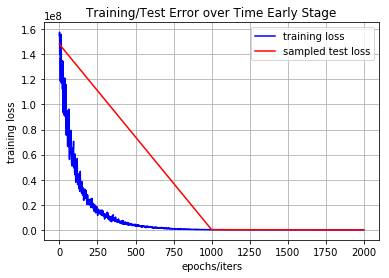

In [110]:
plt.plot(msetrain_history[:2000], 'b', label = "training loss")
plt.plot([1000*i for i in range(len(msetest_history))][:3], msetest_history[:3], 'r', label = "sampled test loss")
plt.title('Training/Test Error over Time Early Stage' )
plt.grid(True)
plt.xlabel('epochs/iters')
plt.ylabel('training loss')
plt.legend()

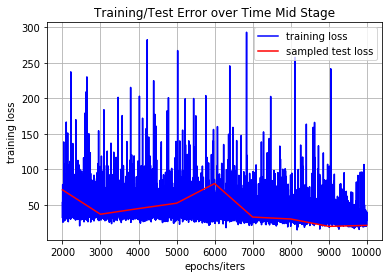

In [111]:
plt.plot([i for i in range(2000,10001)], msetrain_history[2000:10001], 'b', label = "training loss")
plt.plot([1000*i for i in range(len(msetest_history))][2:11], msetest_history[2:11], 'r', label = "sampled test loss")
plt.title('Training/Test Error over Time Mid Stage' )
plt.grid(True)
plt.xlabel('epochs/iters')
plt.ylabel('training loss')
plt.legend()

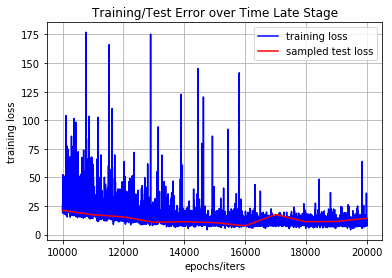

In [112]:
plt.plot([i for i in range(10001,len(msetrain_history))], msetrain_history[10001:], 'b', label = "training loss")
plt.plot([1000*i for i in range(len(msetest_history))][10:], msetest_history[10:], 'r', label = "sampled test loss")
plt.title('Training/Test Error over Time Late Stage' )
plt.grid(True)
plt.xlabel('epochs/iters')
plt.ylabel('training loss')
plt.legend()

The preceding plots can be found here without needing to be rerun:
https://gyazo.com/890798c933676e6701dd1343966fbdf7 


https://gyazo.com/3aa26a6d38aa4db3d6684016d303a2b3

In [118]:
############################################################
###### train your model using a neural network trick #######
############################################################

def create_normed_dropout_model(num_inputs, num_layers, nodeslist, num_outputs,keep_prob):
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, num_outputs])

    # create a fully connected network layer
    hidden_layer = input_ph
    
    for i in range(num_layers):
        hidden_layer = tf.contrib.slim.fully_connected(
            hidden_layer,
            nodeslist[i],
            weights_initializer=tf.truncated_normal_initializer(),
            activation_fn=tf.nn.relu,
            scope="hidden_{}".format(i),
            reuse=tf.AUTO_REUSE)
        
        mean, variance = tf.nn.moments(hidden_layer, axes=0)
        hidden_layer = tf.nn.batch_normalization(
            hidden_layer,
            mean,
            variance,
            offset=0,
            scale=None,
            variance_epsilon=1,
            name=None
        )
        
        

    drop_out = tf.nn.dropout(hidden_layer, keep_prob)  # DROP-OUT here
    # create an output layer
    output_layer = tf.contrib.slim.fully_connected(
        drop_out,
        1,
        weights_initializer=tf.random_uniform_initializer(0,1),
        activation_fn=None,
        scope="output",
        reuse=tf.AUTO_REUSE)
    

    return input_ph, output_ph, output_layer

In [120]:
tf.reset_default_graph()

input_ph, output_ph, output_pred = create_normed_dropout_model(3, 2, [32,32], 1, keep_prob=0.5)

# create a tensorflow session
sess = tf.Session()

# create loss as MSE (can switch to cross entropy or KL divergence)
mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))
#mse = tf.losses.mean_squared_error(output_pred, output_ph)

# create optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# initialize variables
sess.run(tf.global_variables_initializer())

# create saver to save model variables
saver2 = tf.train.Saver()

# run training
batch_size = 100
iters= 20001 #num epochs
msetrain_history = np.zeros(iters) #maintain the training loss
msetest_history = np.zeros(iters//1000 + 1) #evaluate against tet/validation
for training_step in range(iters):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(train_set.index), size=batch_size)
    inputcolslist = ["Speed", "Gap", "Lead_Speed"]
    input_batch = np.array(train_set[inputcolslist])[indices]
    output_batch = np.array(train_set[["Acceleration"]])[indices]
    test_indices = np.random.randint(low=0, high = len(test_set.index), size =batch_size)
    test_input = np.array(test_set[inputcolslist])[test_indices]
    test_output = np.array(test_set[["Acceleration"]])[test_indices]

    # run the optimizer and get the mse
    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
    msetrain_history[training_step] =  mse_run
    
    # print the mse every so often
    if training_step % 1000 == 0:
        test_pred = sess.run(output_pred, feed_dict={input_ph: test_input})
        mse_test = np.mean(0.5 * np.square(test_pred - test_output))
        msetest_history[training_step//1000] = mse_test
        print("testloss: ", msetest_history[training_step//1000])
        print("trainingloss:")
        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))
        saver2.save(sess, '/tmp/model.ckpt')



testloss:  30.4077695426
trainingloss:
0000 mse: 24.118
testloss:  11.5688336992
trainingloss:
1000 mse: 8.290
testloss:  9.81788627086
trainingloss:
2000 mse: 10.586
testloss:  10.2865378834
trainingloss:
3000 mse: 9.810
testloss:  11.4881477178
trainingloss:
4000 mse: 9.064
testloss:  9.68685699131
trainingloss:
5000 mse: 8.456
testloss:  9.28299183426
trainingloss:
6000 mse: 9.605
testloss:  7.79098150417
trainingloss:
7000 mse: 8.298
testloss:  9.67694799755
trainingloss:
8000 mse: 9.302
testloss:  8.64989863501
trainingloss:
9000 mse: 6.645
testloss:  12.2322851354
trainingloss:
10000 mse: 9.206
testloss:  11.6497766075
trainingloss:
11000 mse: 10.808
testloss:  9.17139454897
trainingloss:
12000 mse: 9.927
testloss:  8.23674704453
trainingloss:
13000 mse: 9.514
testloss:  7.98853639548
trainingloss:
14000 mse: 10.563
testloss:  12.7653993173
trainingloss:
15000 mse: 6.000
testloss:  9.47310654177
trainingloss:
16000 mse: 10.176
testloss:  7.65901795648
trainingloss:
17000 mse: 6.7

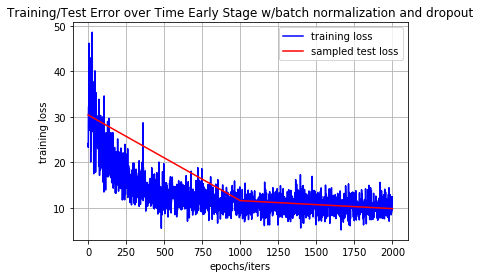

In [126]:
plt.plot(msetrain_history[:2000], 'b', label = "training loss")
plt.plot([1000*i for i in range(len(msetest_history))][:3], msetest_history[:3], 'r', label = "sampled test loss")
plt.title('Training/Test Error over Time Early Stage w/batch normalization and dropout' )
plt.grid(True)
plt.xlabel('epochs/iters')
plt.ylabel('training loss')
plt.legend()

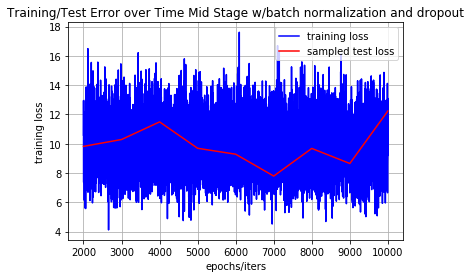

In [127]:
plt.plot([i for i in range(2000,10001)], msetrain_history[2000:10001], 'b', label = "training loss")
plt.plot([1000*i for i in range(len(msetest_history))][2:11], msetest_history[2:11], 'r', label = "sampled test loss")
plt.title('Training/Test Error over Time Mid Stage w/batch normalization and dropout' )
plt.grid(True)
plt.xlabel('epochs/iters')
plt.ylabel('training loss')
plt.legend()

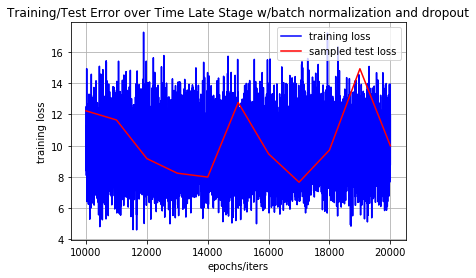

In [128]:
plt.plot([i for i in range(10001,len(msetrain_history))], msetrain_history[10001:], 'b', label = "training loss")
plt.plot([1000*i for i in range(len(msetest_history))][10:], msetest_history[10:], 'r', label = "sampled test loss")
plt.title('Training/Test Error over Time Late Stage w/batch normalization and dropout' )
plt.grid(True)
plt.xlabel('epochs/iters')
plt.ylabel('training loss')
plt.legend()

The previous graphs can be found here. https://gyazo.com/39676703a687de95b7cf1d1ce2cad656

However, note that there is more fluctuation around the minimum/local minima near the end. This is because with dropout and batch normalization, we started with low loss and then CONVERGE MUCH FASTER (maybe normaliziation gives us things that we think are nice minima but was not that optimal to begin with since our data is now just small = small outputs = smaller losses). So an overall graph might be nicer:

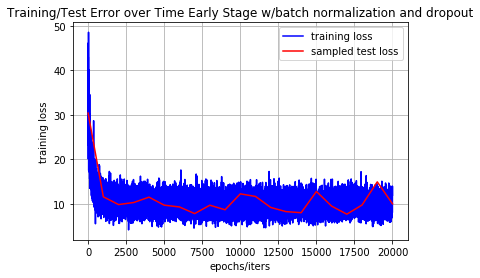

In [129]:
plt.plot(msetrain_history, 'b', label = "training loss")
plt.plot([1000*i for i in range(len(msetest_history))], msetest_history, 'r', label = "sampled test loss")
plt.title('Training/Test Error over Time Early Stage w/batch normalization and dropout' )
plt.grid(True)
plt.xlabel('epochs/iters')
plt.ylabel('training loss')
plt.legend()

You can see that a quick convergence to the minima with some stochastic fluctuations occur even after only 1000 iterations of SGD.

https://gyazo.com/6c9349ba2fcd66fb34a9f5e8e3d789cd

# Question 2: Traffic Signal Timing with DQN

In this problem, you will implement your first reinforcement learning algorithm: DQN. The algorithm will then be used to control traffic lights in a simple network. Specifically, we consider a single intersection as seen in the figure below, with lanes of length 300 m on either direction and vehicles entering the network from the north-south and east-west directions at a rate of 300 veh/hr and 100 veh/hr, respectively. We choose to study the problem of traffic light signal control using DQN because of the discretizable nature of the action space for the resulting MDP (see the [implementation of the environment](https://github.com/flow-project/flow/blob/master/flow/envs/green_wave_env.py) for more).

<img src="img/dqn_network.png" width="600">

Before we begin optimizing the performance of the traffic light in the given problem, let us first analyze the performance of the baseline form of this problem. Such baselines in Flow can be extracted by simulating the dynamical behavior the network in the absence of any reinforcement learning agent. In this case, we consider a baseline signal schedule where the portion of time when the light is equal for both directions. This control strategy is not optimal, and is symptomatic of one of the primary sources of traffic congestion today.

The below cell instantiates the above described network and computes the average delay of vehicles in the system. Run it once and look at the average return that you get. Note that, while it is not necessary, if you interested in further understanding the inner working of the below lines of code, we recommend you review the following [tutorial on traffic lights](https://github.com/berkeleyflow/flow/blob/master/tutorials/tutorial08_traffic_lights.ipynb) in Flow.

In [3]:
import numpy as np
from flow.envs import PO_TrafficLightGridEnv
from flow.core.experiment import SumoExperiment
from hw2_utils import create_scenario, env_params
from hw2_utils import sumo_params_test as sumo_params

scenario = create_scenario()
env = PO_TrafficLightGridEnv(env_params, sumo_params, scenario)
exp = SumoExperiment(env, scenario)

num_runs = 2
results = exp.run(num_runs, env_params.horizon)
total_return = np.mean(results["returns"])
print("-----------------")
print('The total return across %d runs is %.3f seconds' %(num_runs, total_return))

Round 0, return: 265.9383312068948
Round 1, return: 262.50088011116526
Average, std return: 264.21960565903004, 1.7187255478647785
Average, std speed: 11.880784504834846, 0.0214035455790218
-----------------
The total return across 2 runs is 264.220 seconds


### a. Creating a neural network

We now begin to design the various constituents of our algorithm. The algorithm we will create here, as well as most online RL algorithms in practice, consists of four primary components:

- a **function approximator**, either for the policy or the value/Q function
- a method for **computing actions**,
- a **sample generator**,
- and an **optimization scheme**.

The function approximator is the part of the control strategy that is periodically trained by the RL algorithm. In the case of DQN, the policy denotes the RL agent's estimation of the Q function ($Q : S \to \mathbb{R}^A$), which computes the value of any given action $a_i \in [0, A-1]$ from a starting state $s \in S$.

For this problem, let us consider a simple feed forward network of hidden shape *[100, 50, 25]* with a *ReLU* nonlinearity for the hidden layers, and a weighted sum of with *no nonlinearity* for the output layer. Moreover, let the initial values of all weights in the network to set to truncated normal values with standard a devaition of 1.0, and all biases be initially set to zero. In the below cell, implement this neural network and have the method return the tensorflow Variable corresponding to the output layer. Note that the scope of the output layer should match the one specified in the input parameters.

**Hint**: some useful tensroflow classes and methods include: `tf.layers.dense`, `tensorflow.contrib.slim.fully_connected`, `tf.nn.relu`, `tf.truncated_normal_initializer`, `tf.zeros_initializer`, 

In [10]:
def fully_connected_network(inputs, num_actions, scope):
    """Creates a fully-connected neural network computation graph.

    Parameters
    ----------
        inputs : tf.Placeholder
            placeholders for the input features
        num_actions : int
            range of actions that can be performed by the policy. Actions 
            returned must be between 0 to num_actions, inclusive.
        scope : str
            a label that is used to call a specific component in the 
            computation graph

    Returns
    -------
        tf.Variable
            the output player that is responsible for returning the neural
            network estimation. The scope of the output layer should match 
            the one specified in the above parameters.
    """
    ##############################################
    ##### construct your neural network here #####
    #############################################
    
    

    # number of output actions
    num_outputs = num_actions


    # create a fully connected network layers
    hidden_layer_1 = tf.contrib.slim.fully_connected(
        inputs,                                               # input placeholder
        100,                                                     # number of hidden nodes
        activation_fn = tf.nn.relu,                               # nonlinearity (None means linear combination)
        weights_initializer=tf.truncated_normal_initializer(stddev=1.0),  # initializer for the weights
        biases_initializer = tf.zeros_initializer(), #initializes bias
        scope=scope+'1',                                         # name of the node
        reuse=tf.AUTO_REUSE)
    
    hidden_layer_2 = tf.contrib.slim.fully_connected(
        hidden_layer_1,                                               # input placeholder
        50,                                                     # number of hidden nodes
        activation_fn = tf.nn.relu,                               # nonlinearity (None means linear combination)
        weights_initializer=tf.truncated_normal_initializer(stddev=1.0),  # initializer for the weights
        biases_initializer = tf.zeros_initializer(), #initializes bias
        scope= scope + "2",                                         # name of the node
        reuse=tf.AUTO_REUSE)
    
    hidden_layer_3 = tf.contrib.slim.fully_connected(
        hidden_layer_2,                                               # input placeholder
        25,                                                     # number of hidden nodes
        activation_fn = tf.nn.relu,                               # nonlinearity (None means linear combination)
        weights_initializer=tf.truncated_normal_initializer(stddev=1.0),  # initializer for the weight
        biases_initializer = tf.zeros_initializer(),    #initializes bias  
        scope= scope + "3",                                         # name of the node
        reuse=tf.AUTO_REUSE)

    # create an output layer
    output_layer = tf.contrib.slim.fully_connected(
        hidden_layer_3,                                           # input placeholder
        num_outputs,                                            # number of hidden nodes
        activation_fn = tf.nn.relu,                               # nonlinearity (None means linear combination)
        weights_initializer=tf.truncated_normal_initializer(stddev=1.0),  # initializer for the weights
        biases_initializer = tf.zeros_initializer(), #initializes bias
        scope="output",                                         # name of the node
        reuse=tf.AUTO_REUSE)



    return output_layer

### b. Computing actions

Next, we impelment our method for computing actions. In DQN, the action taken by the RL agent is chosen to be the action which maximizes the Q value estimated by the policy in section a). Moreover, in order to promote exploration of the task space, the agent performs a random action with probability $\epsilon$, where $\epsilon$ is an exploration rate term that in practice starts high, and is periodically annealed to a smaller value. Mathematically, this is written as:

\begin{equation}
a_t(s_t) = 
\begin{cases}
randint(0, A-1) && \text{if }uniform(0,1) < \epsilon \\
\underset{a}{\arg\max}(Q(s_t,a))  && \text{otherwise}
\end{cases}
\end{equation}

Fill in the below cell to compute and return appropriate actions for the given state.

In [5]:
def compute_action(sess, obs, obs_ph, num_actions, q_func, exploration_rate):
    """Computes an action from the RL policy given an observation.

    With probability exploration_rate, the action is a random integer within 
    the range of the action space.

    Parameters
    ----------
        sess : tf.session
            The tensorflow session
        obs : list
            The observation
        obs_ph : tf.placeholder
            placeholder for the observation
        num_actions : int
            range of actions (the returned action must be an integer between
            0 and num_actions-1, inclusive)
        exploration_rate : float
            Probability of selecting action other than the argmax of the 
            q function

    Returns
    -------
        int
            action to take
    """
    ##################################################
    ##### implement your action computing method #####
    if np.random.uniform(0,1) < exploration_rate: #epsilon = exploration_rate
        return np.random.randint(num_actions) #A = num_actions
    
    
    ##################################################
    outputs = sess.run(q_func, feed_dict = {obs_ph: obs}) #obs is JUST the states as input! no i/o pair
    action = np.argmax(outputs)
    
    
    return action

### c. Collecting samples from OpenAI gym environments

All RL algorithms require data to train the parameters of their policies. This is generally done by allowing the policy to specify an action $a_t(s_t)$ and then having a simulation environment return an updated state $s_{t+1}$ as well as a reward value associated with the state/action paire $r_t(s_t,a_t)$. In the lectures, we discussed the library "OpenAI gym", which serves to standardize the process of collecting data across multiple RL algorithms. Gym environments do so by relying on two methods for updating the simulation:

- **step**: Advances the simulation by one step. Takes as an input an action from the agent, and returns the next state, the reward, a boolean term to specify whether the rollout completed prematurely, and an additional (optional) info dict.
- **reset**: Returns the environment to some initial state. Unlike the step method, it does not take as an input any action, and only returns the initial state of the environment.

The below method is designed to collect a single rollout worth of simulation data from gym-compatible environments and return the samples as a list of dictionary elements. Fill in the missing elements of this method.

In [30]:
def rollout(env, sess, s_t_ph, q_func, exploration_policy):
    """Executes a single rollout of the environment.

    Parameters
    ----------
        env : gym.Env
            OpenAI gym-compatible environment
        sess : tf.Session
            blank
        s_t_ph : tf.Placeholder
            placeholder for the input states
        q_func : tf.Variable
            output layer to the Q function, which returns expected values
        exploration_policy : object
            an object that provides appropriate exploration rates for the
            action computing procedure

    Returns
    -------
        list of dict
            each element is a new sample, with each dict containing keys 
            for "state", "action", "next_state", "reward", and "done_mask"
    """
    # the samples list will contain information from all new simulation steps
    samples = []

    # start a new rollout by resetting the environment and collecting the initial state
    ### FILL IN ###
    init_state = env.reset()
    num_actions = env.action_space.n
    
    obs = init_state

    for i in range(env_params.horizon):
        # compute the action from the compute_action method from part b)
        ### FILL IN ###
        
        opt_a = compute_action(sess, [obs], s_t_ph, num_actions, q_func, exploration_policy(i)) 
        #must include extra dimensional layer to observation!

        # advance the environment once and collect the next state, reward, done, 
        # and info parameters from the environment
        ### FILL IN ###
        s_tplus1, r_tplus1, done, info = env.step(opt_a)
        

        # add to the samples list a dict containing: "state", "action", "next_state", 
        # "reward", and "done_mask"
        samples.append({"state": obs,       ### FILL IN ###
                        "action": opt_a,      ### FILL IN ###
                        "next_state": s_tplus1,  ### FILL IN ###
                        "reward": r_tplus1,      ### FILL IN ###
                        "done_mask": done})  ### FILL IN ###
        obs = s_tplus1

        # if the environment returns a True for the done parameter, end the rollout 
        # before the time horizon is met
        ### FILL IN ###
        if done:
            break

    return samples

### d. Training

In this section, we implement the core of our RL algorithm: the training operation. For the standard form of DQN, training occurs at the level of the Q function $Q(s,a)$ by optimizing over the loss:

\begin{equation}
\hat{Q}(s_t,a_t) = \big( R(s_t,a_t) + \gamma \cdot \max_a Q_\text{target}(s_{t+1},a) \big) - Q(s_t,a_t)
\end{equation}

where $\gamma$ is a discount rate and $Q_\text{target}$ is the Q target function that is stored separately from the Q value and updated less frequently in order to further stabilize the training procedure.

The below cell is responsible for constructing the tensforflow placeholders and methods that will be called during the optimization scheme. Following the comments placed on each of the empty operations, and referring to the lecture on DQN, fill in the remainder of this cell.

**Hint**: some useful tensroflow classes and methods include: `tf.placeholder`, `tf.one_hot`, `tf.losses.huber_loss`, `tf.train.AdamOptimizer`, `tf.clip_by_norm`, `tf.assign`, `tf.group`, `tf.global_variables_initializer`

In [21]:
def construct_update(env, gamma, learning_rate, norm_clipping):
    """Constructs the necessary tensforflow components needed to execute
    the DQN optimization scheme.

    Parameters
    ----------
        env : gym.Env
            OpenAI gym-compatible environment
        gamma : float
            discount rate
        learning_rate : float
            used during the optimization step
        norm_clipping : float
            saturation point for the gradients

    Returns
    -------
        tf.Variable
            output layer to the Q function
        list of tf.Placeholder
            several placeholders that we create to later feed data through
        tf.Operation
            method for updating the parameters of the Q function
        tf.Operation
            method for transferring the parameters of the Q function to the 
            Q target
        tf.Session
            tensorflow session
    """
    # initialize a tensorflow session
    sess = tf.Session()

    # number of discrete actions the agent can perform
    num_actions = env.action_space.n
    # number of elements in the observation space
    obs_size = env.observation_space.shape[0]

    # actions placeholder (use tf.int32 as the dtype)
    a_t_ph =  tf.placeholder(dtype=tf.int32, shape=[None], name='a_t_ph')   ### FILL IN ###
    # state placeholder (use tf.int32 as the dtype)
    s_t_ph = tf.placeholder(tf.float32, shape=[None, obs_size], name='s_t_ph')  ### FILL IN ###
    # next state placeholder (use tf.int32 as the dtype)
    s_tp1_ph = tf.placeholder(tf.float32, shape=[None, obs_size], name='s_tp1_ph')  ### FILL IN ###
    # reward placeholder (use tf.int32 as the dtype)
    rew_ph = tf.placeholder(tf.float32, shape=[None], name='rew_ph')  ### FILL IN ###
    # done placeholder (use tf.int32 as the dtype)
    done_ph = tf.placeholder(tf.float32, shape=[None], name='done_ph')  ### FILL IN ###
    
    ph_list = s_t_ph, s_tp1_ph, a_t_ph, rew_ph, done_ph

    # construct your q functions using the method from part a) and give it the scope "q_func"
    q = fully_connected_network(s_t_ph, num_actions, "q_func")### FILL IN ###

    # get the weights of your q function
    q_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                 scope=tf.get_variable_scope().name + "q_func")

    # construct the q target using the method from part a) and give it the scope "q_target"
    q_target = fully_connected_network(s_tp1_ph, num_actions, 'q_target')### FILL IN ###

    # get the weights of your q function
    q_target_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                        scope=tf.get_variable_scope().name + "q_target")

    # perform the update step here. Be sure to use "gamma" and "learning_rate"
    # as specified by the input parameters, and clip the gradients by the 
    q_val = rew_ph + gamma*(1-done_ph)*tf.reduce_max(q_target, axis=1)
    q_pred = tf.reduce_max(q*tf.one_hot(a_t_ph, num_actions), axis=1)
    loss = tf.losses.huber_loss(q_val, q_pred) #makes less sensitive to noise
    
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
    grad_var_list = opt.compute_gradients(loss, var_list=q_params)
    # Gives a list of (grad, var) pairs w.r.t. q_params only (grad compute at var)
    grad, var = zip(*grad_var_list) #zip together the grads and the vars and separates
    grad, _ = tf.clip_by_global_norm(grad, norm_clipping)# "norm_clipping" term 
    #separated just to apply norm clipping
    update = opt.apply_gradients(grad_var_list)

    # create an assignment operator q_target_params to copy the q function params
    # to the q_target params. "update_target_expr" will be called periodically to 
    # copy Q network to target Q network. You will want to use the variables q_params
    # and q_target_params
    ### FILL IN ###
    update_target_expr = []
    
    sorted_q_params = sorted(q_params, key=lambda v: v.name)
    sorted_target_params = sorted(q_target_params, key=lambda v: v.name)
    
    for i in range (len(sorted_q_params)):
        update_target_expr.append(tf.assign(sorted_target_params[i], sorted_q_params[i]))
    update_target_expr  = tf.group(*update_target_expr)

    # initialize all the variables
    ### FILL IN ###
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    return q, ph_list, update, update_target_expr, sess

The next method is responsible for executing the entire training session. In this method, the replay buffer is periodically updated with data from the rollouts in part c) and a series of update steps are performed after every rollout. Note that this is somewhat different from the regular DQN approach, where the Q functions are trained after a number of steps instead of rollouts. Finally, after a number of rollouts, the parameters of the target Q function are modified to match those of the actual Q function.

With the above description in mind, fill in the below cell to complete your DQN algorithm.

In [55]:
import os

def train(env,
          num_iterations=20,
          steps_per_iteration=10000,
          num_opt_steps=10,
          batch_size=1000,
          learning_rate=1e-4,
          buffer_size=50000,
          initial_explore_rate=1.0,
          final_explore_rate=0.02,
          anneal_rate=int(1e5),
          norm_clipping=10, 
          gamma=0.5):
    """Runs an entire training session of DQN on an environment.

    Note that the hyper-parameters are inputs to this method in order to 
    facilitate hyper-parameter tuning.

    Parameters
    ----------
        env : gym.Env
            OpenAI gym-compatible environment
        num_iterations : int
            number of training iterations before training stops
        steps_per_iteration : int
            number of steps to perform before the parameters of the 
            Q target are updated
        num_opt_steps : int
            number of optimization steps to take after every rollout
        learning_rate : float
            used by the optimizer
        buffer_size : int
            maximum number of elements the replay buffer can hold
        initial_explore_rate : float
            used by the exploration strategy
        final_explore_rate : float
            used by the exploration strategy
        anneal_rate : int
            used by the exploration strategy
        batch_size : int
            number of samples used to compute the gradient
        norm_clipping : float
            saturation point for the gradients
        gamma : float
            discount rate

    Returns
    -------
        list of float
            a list of average returns per ten rollouts
    """
    # define the replay buffer
    replay_buffer = [] ### FILL IN ###

    # define the exploration policy (the y term corresponds to the number of previous steps)
    exploration_policy_offset = lambda x,y: max(initial_explore_rate - 1/anneal_rate * (x+y), final_explore_rate)

    # collect the necessary tensorflow-specific components
    q_func, ph_list, update, update_target_expr, sess = construct_update(env, gamma, learning_rate, norm_clipping)
    s_t_ph, s_tp1_ph, a_t_ph, rew_ph, done_ph = ph_list

    # to store cumulative returns per rollout
    cumulative_return_per_rollout = []
    cumulative_return_per_ten_rollouts = []

    # create saver to save model variables
    saver = tf.train.Saver()
    
    # variables used during saving the checkpoint
    current_dir = os.getcwd()
    max_cumulative_ret = -float("inf")

    total_steps = 0
    num_rollouts = 0
    for i in range(num_iterations):
        while total_steps < steps_per_iteration * (i+1):
            # update the policy with the number of previous timesteps
            exploration_policy = lambda x: exploration_policy_offset(x, total_steps)

            # perform one rollout of the policy on the environment and collect the samples
            samples = rollout(env, sess, s_t_ph, q_func, exploration_policy)
            total_steps += len(samples)
            num_rollouts += 1

            # update the cumulative rewards terms (so that we may visualize the 
            # improvements later)
            cumulative_return_per_rollout.append(sum(sample["reward"] for sample in samples))

            # store cumulative returns in means of 10 rollouts
            if num_rollouts % 10 == 0:
                cumulative_return_per_ten_rollouts.append(
                    np.mean(cumulative_return_per_rollout))
                cumulative_return_per_rollout = []

            for sample in samples:
                # add to the replay buffer a dict containing: "states", "next_states", 
                # "actions", "rewards", and "done_masks". Note that the number of elements 
                # should should match the input parameter **buffer_size**.
                ### FILL IN ###
                replay_buffer.append(sample) #this dict is simply obtained 
                if len(replay_buffer) > buffer_size:
                    replay_buffer.pop(0)

            # perform actual training here
            for _ in range(num_opt_steps):
                # collect a subset of samples from the replay buffer with length 
                # **batch_size**
                ### FILL IN ###

                # perform the update process by calling the update method and feeding 
                # the samples to their corresponding placeholders
                sample_indices = np.random.randint(0, len(replay_buffer), size=batch_size)
                batch = np.array(replay_buffer)[sample_indices]

                # perform the update process by calling the update method and feeding 
                # the samples to their corresponding placeholders
                feed_dict = {
                    s_t_ph: np.array([sample['state'] for sample in batch]),
                    s_tp1_ph: np.array([sample['next_state'] for sample in batch]),
                    a_t_ph: np.array([sample['action'] for sample in batch]),
                    rew_ph:  np.array([sample['reward'] for sample in batch]),
                    done_ph: np.array([sample['done_mask'] for sample in batch])
                }
                sess.run([update], feed_dict=feed_dict)  ### FILL IN ###
                

        # update the parameters of the target q function to match those of the actual
        # q function
        sess.run(update_target_expr)  ### FILL IN ###

        # used to monitor progress
        print('------------------')
        print('|the total reward of 10 rollouts was:', np.mean(cumulative_return_per_rollout[-10:]))
        print('|the exploration fraction is:', exploration_policy(total_steps))
        print('|number of episodes so far:', len(cumulative_return_per_rollout))
        print('|steps so far:', total_steps)
        print('------------------\n')

        # save the model for later viewing (save only the max)
        if np.mean(cumulative_return_per_rollout[-10:]) > max_cumulative_ret:
            max_cumulative_ret = np.mean(cumulative_return_per_rollout[-10:])
            saver.save(sess, os.path.join(current_dir, "model.ckpt"))

    return cumulative_return_per_ten_rollouts

You can test your implementation of DQN on the "CartPole-v0" environment below.

In [31]:
import tensorflow as tf
import gym

tf.reset_default_graph()
env = gym.make("CartPole-v0")
avg_reward_per_iteration = train(env, learning_rate=5e-6)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
------------------
|the total reward of 10 rollouts was: nan
|the exploration fraction is: 0.7997799999999999
|number of episodes so far: 0
|steps so far: 10011
------------------



/home/charlie/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/charlie/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


------------------
|the total reward of 10 rollouts was: 12.0
|the exploration fraction is: 0.6
|number of episodes so far: 1
|steps so far: 20000
------------------

------------------
|the total reward of 10 rollouts was: 49.0
|the exploration fraction is: 0.3994399999999999
|number of episodes so far: 3
|steps so far: 30028
------------------

------------------
|the total reward of 10 rollouts was: 13.6666666667
|the exploration fraction is: 0.19985999999999993
|number of episodes so far: 9
|steps so far: 40007
------------------

------------------
|the total reward of 10 rollouts was: 15.3333333333
|the exploration fraction is: 0.02
|number of episodes so far: 9
|steps so far: 50004
------------------

------------------
|the total reward of 10 rollouts was: 18.2857142857
|the exploration fraction is: 0.02
|number of episodes so far: 7
|steps so far: 60002
------------------

------------------
|the total reward of 10 rollouts was: 14.8571428571
|the exploration fraction is: 0.02

We are now finally ready to train your traffic signal schedule. The below cell executes one complete instance of training. Run this cell, and in the cell immediately below it, plot the average return per iteration. **Note**: If all went well, it is still possible that your algorithm's raining curve is still very noisy; for this reason, we will in the final problem look to augmentations of DQN, namely double q-learning.

In [56]:
import tensorflow as tf
import gym
from gym.envs.registration import register
from hw2_utils import create_scenario, env_params
from hw2_utils import sumo_params_train as sumo_params

tf.reset_default_graph()
scenario = create_scenario()

# register the Flow gym environment with OpenAI gym
env_name = "PO_TrafficLightGridEnv"
try:
    register(
        id=env_name + "-v0",
        entry_point='flow.envs:' + env_name,
        max_episode_steps=env_params.horizon,
        kwargs={
            "env_params": env_params,
            "sumo_params": sumo_params,
            "scenario": scenario
        }
    )
except:  # this will happen if you already registered the environment
    pass
env = gym.envs.make(env_name + "-v0")

# perform the training iterations for set duration
avg_reward_per_iteration = train(env)

------------------
|the total reward of 10 rollouts was: 258.021361364
|the exploration fraction is: 0.8
|number of episodes so far: 5
|steps so far: 10000
------------------



KeyboardInterrupt: 

Text(0,0.5,'Reward')

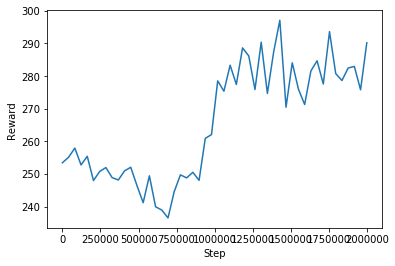

In [37]:
######################################
###### plot learning curve here ######
######################################
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,2000000,50), avg_reward_per_iteration)
plt.xlabel('Step')
plt.ylabel('Reward')

The above plot will be saved at https://gyazo.com/0703d27c94a6b2e4fbf50d418409ab16

### e. Visualizing Learned Control Strategies

Let us now try to visualize the performance of the policy in simulation. In the below cell, we once again run the simulation as we had at the start, expect with the addition of an *rl_actions* method. This method allows us to dictate the actions of RL agents outside of the training loop. Fill in the *rl_actions* method with your new trained policy, and run the cell to visualize your traffic light policy in action. Assuming your algorithm ran as expected, the average delay you receive from the trained policy should be less than the value you received at the start of this the problem before training, meaning that your algorithm has improved traffic flow!

In [59]:
import numpy as np
from flow.envs import PO_TrafficLightGridEnv
from flow.core.experiment import SumoExperiment
from hw2_utils import create_scenario, env_params
from hw2_utils import sumo_params_test as sumo_params

tf.reset_default_graph()

scenario = create_scenario()
env = PO_TrafficLightGridEnv(env_params, sumo_params, scenario)

num_iterations=20
steps_per_iteration=10000
num_opt_steps=10
batch_size=1000
learning_rate=1e-4
buffer_size=50000
initial_explore_rate=1.0
final_explore_rate=0.02
anneal_rate=int(1e5)
norm_clipping=10
gamma=0.5
q_func, ph_list, update, update_target_expr, sess = construct_update(env, gamma, learning_rate, norm_clipping)
s_t_ph, s_tp1_ph, a_t_ph, rew_ph, done_ph = ph_list

# sess = tf.Session()
current_dir = os.getcwd()
saver = tf.train.Saver()
#saver = tf.train.import_meta_graph('model.ckpt.meta')
saver.restore(sess, os.path.join(current_dir, "model.ckpt"))


#placed function here to know what "saver" is
def rl_actions(state):
    ###########################################################
    ###### return the action from the trained Q function ######
    ###########################################################
    #action = compute_action(sess, [state], s_t_ph, num_actions, q_func, exploration_policy(i))
    action = np.argmax(sess.run(q_func, feed_dict={s_t_ph: [state]}))

    return action


##################### DO NOT MODIFY BELOW HERE #####################

# run 10 rollouts of the environment with the RL actions being specified by
# your trained policy
exp = SumoExperiment(env, scenario)
results = exp.run(10, env_params.horizon, rl_actions=rl_actions)

# compute and print the new total delay
total_delay = np.mean(results["returns"])
print("-----------------")
print('The new total return is %.3f seconds' %(total_delay))

INFO:tensorflow:Restoring parameters from /home/charlie/Documents/fall2018class/EECS290O/EE290O/homeworks/homework2/model.ckpt


INFO:tensorflow:Restoring parameters from /home/charlie/Documents/fall2018class/EECS290O/EE290O/homeworks/homework2/model.ckpt


Round 0, return: 312.28536605211247
Round 1, return: 300.69608901938784
Round 2, return: 303.3199040162256
Round 3, return: 304.82415409251576
Round 4, return: 307.1096322262666
Round 5, return: 308.78849553064975
Round 6, return: 310.29339786989914
Round 7, return: 312.01255542127893
Round 8, return: 300.23892129156303
Round 9, return: 303.116707367588
Average, std return: 306.26852228874867, 4.249426634715605
Average, std speed: 8.201504299734491, 0.2527944328411202
-----------------
The new total return is 306.269 seconds


### f. (BONUS) Double Q Learning

Several variants of DQN have arisen over the years as a means of potentially improving training performance. Once such modification is the double Q learning procedure, where the Q functions used to perform action selection and value estimation are separated in order to prevent the Q algorithm from prioritizing optimistically evaluated actions.

In the below cell, extract the method from the previous parts that needs to be updated to implement double Q learning and modify the necessary lines of code. **Hint**: you only need to modify one method.

In [ ]:
##############################################
###### implement double Q learning here ######
##############################################

Once you have implemented the double Q learning modification, test the performance of the new algorithm on the training procedure by plotting the the average and std of the training for both methods across 3 training sessions. Use default hyperparameters for all training instances. You may refer to the supplementary cell below for plotting average/range training curves, or use your own.

In [ ]:
##############################################################
###### train both variants and plot the training curves ######
##############################################################

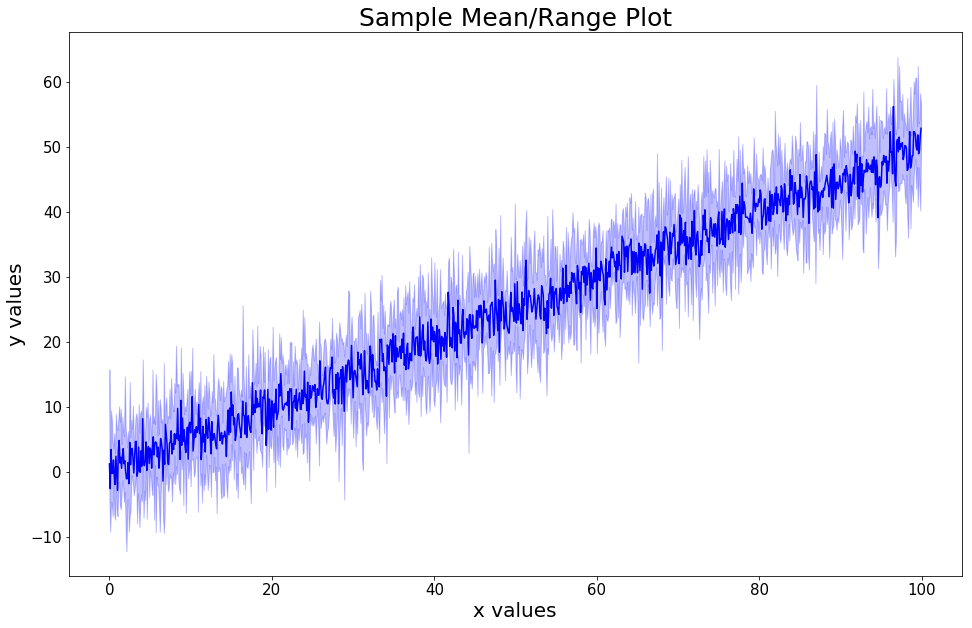

In [42]:
###### Sample Plotting Method ######

import matplotlib.pyplot as plt
import numpy as np

# collect 5 noisy samples of some function (in this case y = 0.5x)
x = np.arange(0, 100, 0.1)
y = [0.5 * x + np.random.normal(0, 5, len(x)) for _ in range(5)]

# Actual plotting past here

plt.figure(figsize=(16,10))
# add line for mean of y values
plt.plot(x, np.mean(y, 0), color="b")
# fill in between min and max with lighter color
plt.fill_between(x, np.min(y, 0), np.max(y, 0), alpha=0.25, color='b')
plt.title("Sample Mean/Range Plot", fontsize=25)
plt.ylabel('y values', fontsize=20)
plt.xlabel('x values', fontsize=20)
plt.tick_params(labelsize=15)
plt.show()